# <span style="color:#DC143C">Part 3</span>

# <span style="font-size:24px; color:#552583;">1. Libraries </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics,preprocessing, model_selection

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm


In [2]:
SEED = 24
lakers_purple = '#552583'
lakers_orange = '#FDB927'

# <span style="font-size:24px; color:#552583;">2. get_device() + bind_gpu() </span>

In [3]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def bind_gpu(data):
    device = get_device()
    if isinstance(data (list, tuple)):
        return [bind_gpu(data_elem) for data_elem in data]
    else:
        return data.to(device, non_blocking=True)

# <span style="font-size:24px; color:#552583;">3. Data handling</span>

In [5]:
X_train_val = pd.read_csv("X_train1.csv")
X_test = pd.read_csv("X_test1.csv")
y_train_val = pd.read_csv("y_train1.csv")
y_test = pd.read_csv("y_test1.csv")

In [6]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val,y_train_val, test_size=0.25,stratify=y_train_val, random_state=SEED)

In [7]:
print("X_train", X_train.shape, type(X_train))
print("y_train", y_train.shape, type(y_train))
print("X_valid", X_val.shape, type(X_val))
print("y_valid", y_val.shape, type(y_val))
print("X_test", X_test.shape, type(X_test))
print("y_test", y_test.shape, type(y_test))

X_train (16381, 16) <class 'pandas.core.frame.DataFrame'>
y_train (16381, 1) <class 'pandas.core.frame.DataFrame'>
X_valid (5461, 16) <class 'pandas.core.frame.DataFrame'>
y_valid (5461, 1) <class 'pandas.core.frame.DataFrame'>
X_test (3855, 16) <class 'pandas.core.frame.DataFrame'>
y_test (3855, 1) <class 'pandas.core.frame.DataFrame'>


### Scaling

In [8]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test =  scaler.transform(X_test)

In [9]:
type(y_train)

pandas.core.frame.DataFrame

# <span style="font-size:24px; color:#552583;">4. Making NN </span>

In [10]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16,10)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2) 
        self.fc2 = nn.Linear(10,12)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(12,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x
        

In [11]:
model = BinaryClassificationModel()
device = get_device()
model = model.to(device)
print(model)

BinaryClassificationModel(
  (fc1): Linear(in_features=16, out_features=10, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=10, out_features=12, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

In [13]:
count_parameters(model)

Layer: fc1, Parameters: 170
Layer: relu1, Parameters: 0
Layer: dropout1, Parameters: 0
Layer: fc2, Parameters: 132
Layer: relu2, Parameters: 0
Layer: dropout2, Parameters: 0
Layer: fc3, Parameters: 13
Layer: sigmoid, Parameters: 0


315

# <span style="font-size:24px; color:#552583;">5.Training NN </span>

In [14]:
N_EPOCHS = 100
BATCH_SIZE = 32

### 5.1. numpyarray, DataFrame to Tensors

In [15]:
X_train,y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy())
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)

X_val, y_val = torch.FloatTensor(X_val), torch.FloatTensor(y_val.to_numpy())
valid_dataset = TensorDataset(X_val, y_val)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy())
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

### 5.2. training function

In [17]:
def train_classification(number_of_epochs):
    best_val_loss = float('inf')
    early_stopping_patience = 10  # broj epoha koji cekamo 
    eps = 1e-6                    # minimalno poboljsanje koje ocekujemo
    steps_since_improvement = 0
    
    losses_train, losses_valid = [], []
    accuracies_train, accuracies_valid = [], []
    device = get_device()

    for epoch in tqdm(range(number_of_epochs), leave=True, desc='Epochs'):
        running_loss_train, running_loss_valid  = 0.0, 0.0
        correct_train, correct_valid  = 0, 0
        total_train, total_valid = 0, 0

        # Training Phase
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())  
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()

            predicted = (outputs > 0.5).float()
            correct_train += (predicted.squeeze() == labels.squeeze()).sum().item()  # Ensure shapes match
            total_train += labels.size(0)

        epoch_loss_train = running_loss_train / len(train_loader)
        epoch_accuracy_train = correct_train / total_train
        losses_train.append(epoch_loss_train)
        accuracies_train.append(epoch_accuracy_train)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_loss_train:.4f}, Train Accuracy: {epoch_accuracy_train:.4f}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.squeeze())  # Fix typo
                running_loss_valid += loss.item()

                predicted = (outputs > 0.5).float()
                correct_valid += (predicted.squeeze() == labels.squeeze()).sum().item()  # Ensure shapes match
                total_valid += labels.size(0)

            epoch_loss_valid = running_loss_valid / len(valid_loader)
            epoch_accuracy_valid = correct_valid / total_valid
            losses_valid.append(epoch_loss_valid)
            accuracies_valid.append(epoch_accuracy_valid)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Valid Loss: {epoch_loss_valid:.4f}, Valid Accuracy: {epoch_accuracy_valid:.4f}")
        
        if best_val_loss > epoch_loss_valid + eps:
            best_val_loss = epoch_loss_valid
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
            if steps_since_improvement == early_stopping_patience:
                print("\nEARLY STOPPING\n")
                break

    return losses_train, accuracies_train, losses_valid, accuracies_valid


In [18]:
losses_train, accuracies_train, losses_valid, accuracies_valid = train_classification(N_EPOCHS)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.6482, Train Accuracy: 0.6350
Epoch [1/100], Valid Loss: 0.6191, Valid Accuracy: 0.6779
Epoch [2/100], Train Loss: 0.6246, Train Accuracy: 0.6720
Epoch [2/100], Valid Loss: 0.6121, Valid Accuracy: 0.6839
Epoch [3/100], Train Loss: 0.6220, Train Accuracy: 0.6790
Epoch [3/100], Valid Loss: 0.6113, Valid Accuracy: 0.6849
Epoch [4/100], Train Loss: 0.6182, Train Accuracy: 0.6787
Epoch [4/100], Valid Loss: 0.6132, Valid Accuracy: 0.6827
Epoch [5/100], Train Loss: 0.6169, Train Accuracy: 0.6809
Epoch [5/100], Valid Loss: 0.6105, Valid Accuracy: 0.6836
Epoch [6/100], Train Loss: 0.6157, Train Accuracy: 0.6796
Epoch [6/100], Valid Loss: 0.6105, Valid Accuracy: 0.6838
Epoch [7/100], Train Loss: 0.6162, Train Accuracy: 0.6799
Epoch [7/100], Valid Loss: 0.6101, Valid Accuracy: 0.6819
Epoch [8/100], Train Loss: 0.6148, Train Accuracy: 0.6806
Epoch [8/100], Valid Loss: 0.6091, Valid Accuracy: 0.6838
Epoch [9/100], Train Loss: 0.6139, Train Accuracy: 0.6814
Epoch [9/100],

# <span style="font-size:24px; color:#552583;">6. Plotting</span>

In [19]:
def plot_classification():
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(len(losses_train)), losses_train, color = lakers_orange, label = 'Train Loss')
    plt.plot(range(len(losses_valid)), losses_valid, color = lakers_purple, label = 'Validation Loss')
    plt.ylim(0.58, 0.7)
    plt.legend(loc = 'best')

    plt.subplot(1,2,2)
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(len(accuracies_train)), accuracies_train, color = lakers_orange , label = 'Train Accuracy')
    plt.plot(range(len(accuracies_valid)), accuracies_valid, color = lakers_purple, label = 'Validation Accuracy' )
    plt.ylim(0.66, 0.8)
    plt.legend(loc = 'best')

    plt.show()

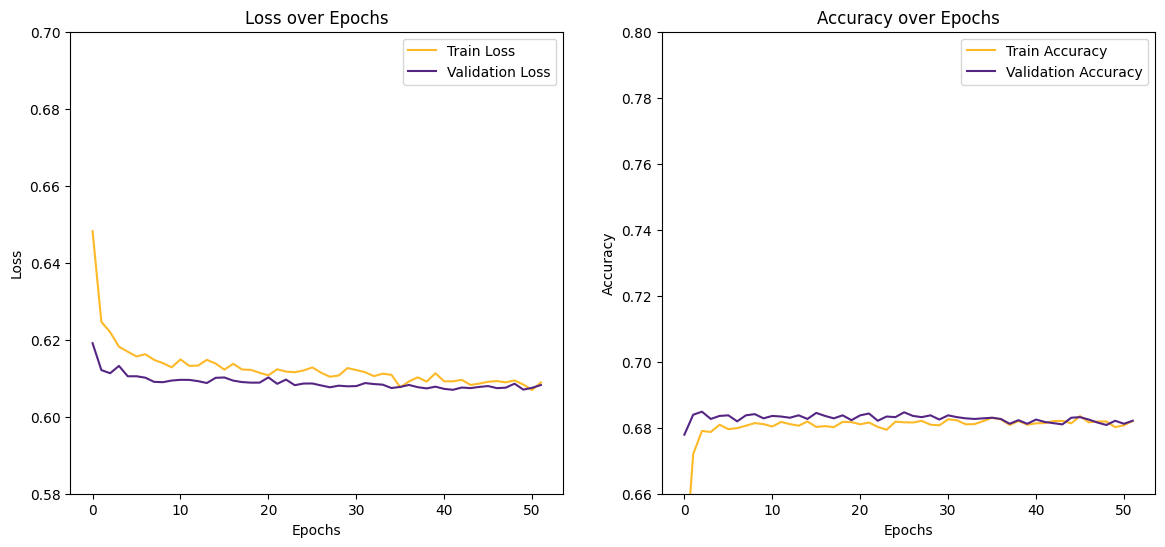

In [20]:
plot_classification()

# <span style="font-size:24px; color:#552583;">7. Evaluation </span>

In [21]:
def evaluate_classification():
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predicted_labels, true_labels = [], []
    device = get_device()

    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs.squeeze(), labels.squeeze()).item()

           
            predicted = (outputs > 0.5).float()
            predicted_labels.extend(predicted.squeeze().tolist())
            true_labels.extend(labels.tolist())

            total_samples += labels.size(0)

    accuracy = metrics.accuracy_score(true_labels, predicted_labels)
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy


In [22]:
avg_loss, accuracy = evaluate_classification()
print(f'Test Set: Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Test Set: Loss: 0.6084, Accuracy: 0.6833


In [23]:
accuracy

0.6832684824902724